In [1]:
import pandas as pd
from itertools import combinations
import itertools
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from random import randrange
import matplotlib
import seaborn as sns
from itertools import permutations

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score,KFold
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

#### Loading data - (labels are NOT log)

In [67]:
x_train  = pd.read_csv("split_1_train_X_Tesla_Cells_20220428.csv")
x_test  = pd.read_csv("split_1_test_X_Tesla_Cells_20220428.csv")
y_train  = pd.read_csv("split_1_train_y_Tesla_Cells_20220428.csv")
y_test  = pd.read_csv("split_1_test_y_Tesla_Cells_20220428.csv")

In [68]:
#removing column of filenames
x_train = x_train.drop('filename', axis = 1)
x_test = x_test.drop('filename', axis = 1)
y_test = y_test.drop('filename', axis = 1)
y_train = y_train.drop('filename', axis = 1)

#using log(labels)
train_labels= y_train["rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties"].tolist()
test_labels= y_test["rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties"].tolist()

In [5]:
X = pd.concat([x_train, x_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)
#concatenating training and testing data
x_data = np.append(x_train,x_test,axis=0)
y_data=np.append(train_labels,test_labels)

#### Creating PCA data

In [6]:
#PCA on concatenated training and test sets
scaler = StandardScaler()
scaler.fit(x_data)
scaled_x_data = scaler.transform(x_data)

Text(0.5, 1.0, 'PCA visual representation of our data')

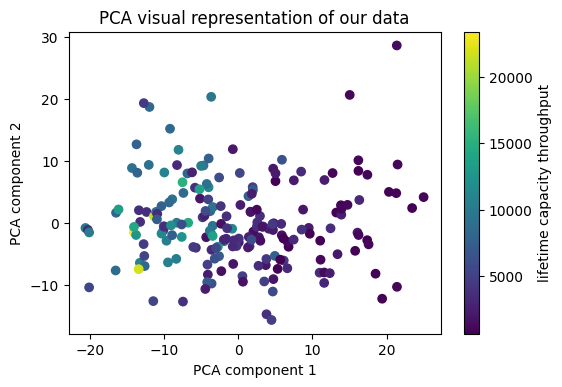

In [7]:
pca = PCA(n_components = 22)
pca_x_data = pca.fit_transform(scaled_x_data)

#plotting first two dim
fig = plt.subplots(dpi = 100)
plt.scatter(pca_x_data[:,0],pca_x_data[:,1],c = y_data)
cbar = plt.colorbar()
cbar.set_label('lifetime capacity throughput')
plt.ylabel('PCA component 2')
plt.xlabel('PCA component 1')
plt.title("PCA visual representation of our data")
# plt.savefig('PCA_components_plot.png')

#### Clustering on the PCA elements

In [8]:
X = pca_x_data
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

Text(0.5, 0, 'PCA component 1')

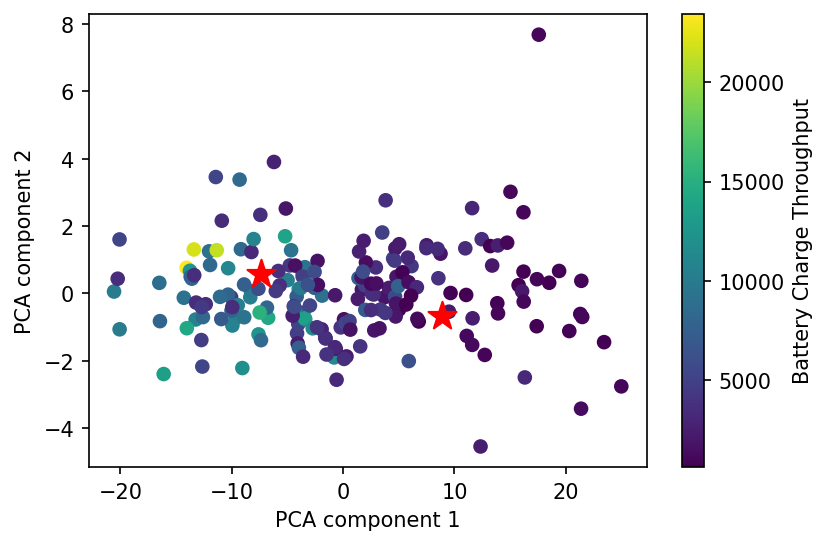

In [62]:
fig = plt.subplots(dpi = 150)
plt.scatter(X[:, 0], X[:, -1], c=y_data)
cbar = plt.colorbar()
cbar.set_label('Battery Charge Throughput')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='*', s = 200)
plt.ylabel('PCA component 2')
plt.xlabel('PCA component 1')
# plt.title('Data points and cluster centroids')

In [158]:
def cluster_input(cluster_x, cluster_y):
    X_train, X_test, y_train, y_test = train_test_split(cluster_x, cluster_y, test_size=0.34)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_x_train = scaler.transform(X_train)
    scaled_x_test = scaler.transform(X_test)

    x_train = scaled_x_train
    x_test = scaled_x_test
    fig = plt.subplots(dpi = 150)
    sns.histplot(y_train, alpha = 0.5)
    sns.histplot(y_test, alpha = 0.5, color = 'r')
    plt.xlabel('Cumulative Charge Throughtput')
    plt.ylabel('Counts')
    legend = ['train set','test set']
    plt.legend(legend)
#     plt.title('Data distribution')
    return x_train, x_test, y_train, y_test

In [151]:
def lasso(x_train, x_test, y_train, y_test):
    lm = linear_model.Lasso(alpha = 2)
    model = lm.fit(x_train, y_train)
    tests = lm.predict(x_test)
    trains = lm.predict(x_train)
    fig = plt.subplots(dpi = 150)
    plt.plot(y_train, y_train,color="gold")
    # plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
    plt.ylabel('Predicted Values')
    plt.xlabel('Real Values')
    plt.title('Random Forest Predictions with 365 features')
    plt.scatter(y_train, trains, label = 'Train' + ' MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(trains, y_train)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(trains, y_train)**0.5))
    plt.scatter(y_test, tests, label = 'Test ' + 'MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(tests, y_test)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(tests, y_test)**0.5))
    
    plt.legend(loc = 'best')

In [146]:
def random_forest_model(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=6, random_state=1)
    regr.fit(x_train, y_train)

    tests = regr.predict(x_test)
    trains = regr.predict(x_train)

    fig = plt.subplots(dpi = 150)
#     plt.scatter(y_train, trains, label = 'Train')
#     plt.scatter(y_test, tests, label = 'Test')

    plt.plot(y_train, y_train,color="gold")
    # plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
    plt.ylabel('Predicted Values')
    plt.xlabel('Real Values')
    plt.title('Random Forest Predictions with 365 features')
    plt.scatter(y_train, trains, label = 'Train' + ' MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(trains, y_train)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(trains, y_train)**0.5))
    plt.scatter(y_test, tests, label = 'Test ' + 'MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(tests, y_test)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(tests, y_test)**0.5))
    
    plt.legend(loc = 'best')

In [159]:
def kernel_model(x_train, x_test, y_train, y_test, alpha, kernel):

    scaled_x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), axis=-1)
    scaled_x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=-1)

    rng = np.random.RandomState(0)
    krr = KernelRidge(alpha=alpha, kernel = kernel)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    krr.fit(scaled_x_train, y_train)
    predictions = krr.predict(scaled_x_test)
    trains = krr.predict(scaled_x_train)

    fig = plt.subplots(dpi = 150)
    # trains = np.exp(trains)
    # predictions = np.exp(predictions)
    # plt.scatter(np.exp(y_train), trains, label = 'trainings')
    # plt.scatter(np.exp(y_test), predictions, label = 'predictions')

    plt.plot(y_train, y_train, color="gold")
    # plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
    plt.ylabel('Predicted Values')
    plt.xlabel('Real Values')
    plt.title('Kernel with 365 features')

#     print('RMSE: ' + str(mean_squared_error(predictions, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(predictions, y_test)))
    #mean_absolute_error(predictions, y_test)
    
    plt.scatter(y_train, trains, label = 'Train' + ' MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(trains, y_train)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(trains, y_train)**0.5))
    plt.scatter(y_test, predictions, label = 'Test ' + 'MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(predictions, y_test)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(predictions, y_test)**0.5))
    
    plt.legend(loc = 'best')

In [160]:
X = x_data
cluster_0_x = X[kmeans.labels_ == 0]
cluster_0_y = y_data[kmeans.labels_ == 0]

cluster_1_x = X[kmeans.labels_ == 1]
cluster_1_y = y_data[kmeans.labels_ == 1]

(69, 364) (36, 364) (69,) (36,)


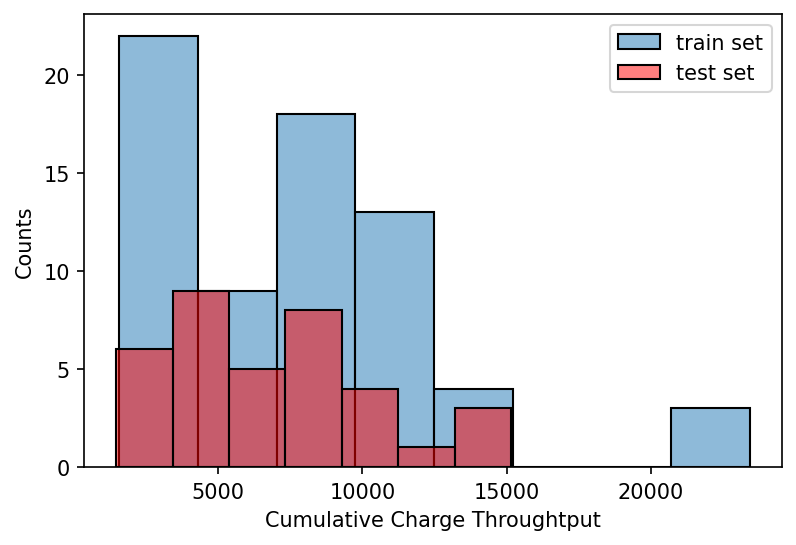

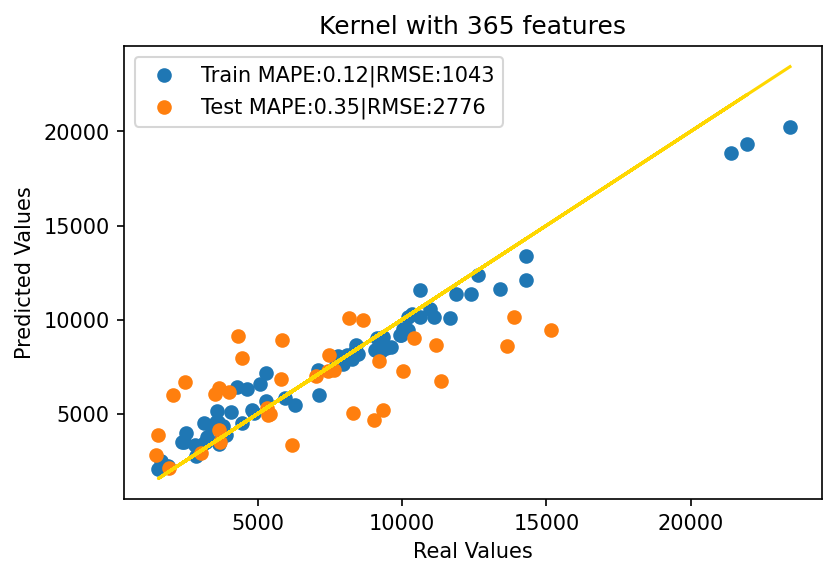

In [177]:
cluster_x = cluster_0_x
cluster_y = cluster_0_y
x_train, x_test, y_train, y_test = cluster_input(cluster_x, cluster_y)
kernel_model(x_train, x_test, y_train, y_test, 0.19, 'laplacian')
# random_forest_model(x_train, x_test, y_train, y_test)
# lasso(x_train, x_test, y_train, y_test)

In [189]:
cluster_0_y.mean()

7325.716251668728

(58, 364) (30, 364) (58,) (30,)


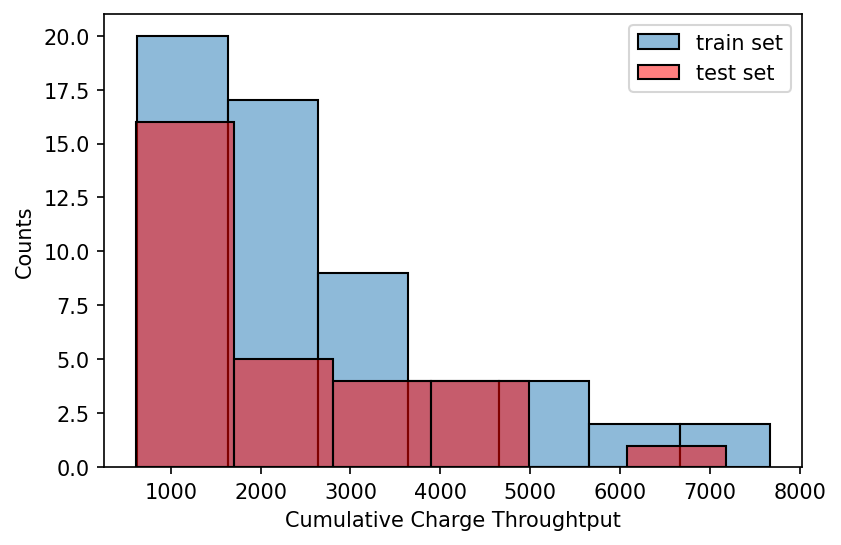

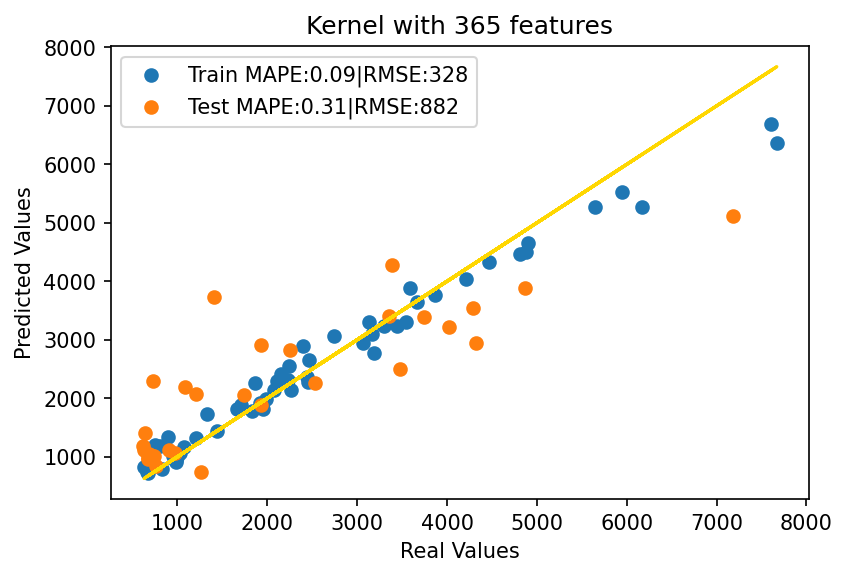

In [187]:
cluster_x = cluster_1_x
cluster_y = cluster_1_y
x_train, x_test, y_train, y_test = cluster_input(cluster_x, cluster_y)
kernel_model(x_train, x_test, y_train, y_test, 0.16, 'laplacian')
# random_forest_model(x_train, x_test, y_train, y_test)

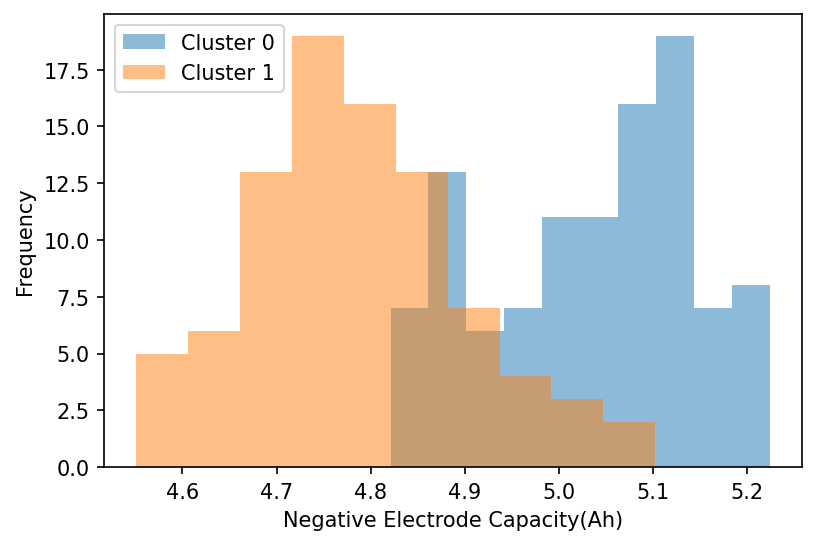

In [78]:
fig = plt.subplots(dpi = 150)
X[kmeans.labels_ == 0]['diag_1_Q_ne::IntracellFeaturesV2'].hist(alpha = 0.5, grid = False, label = 'Cluster 0')
X[kmeans.labels_ == 1]['diag_1_Q_ne::IntracellFeaturesV2'].hist(alpha = 0.5, grid = False, label = 'Cluster 1')
plt.xlabel('Negative Electrode Capacity(Ah)')
plt.ylabel('Frequency')
plt.legend(loc = 'best')

In [83]:
from scipy.stats import pearsonr

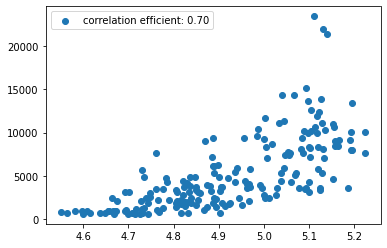

In [90]:
# corr_x = X[kmeans.labels_ == 0]['diag_1_Q_ne::IntracellFeaturesV2']
# corr_y = y[kmeans.labels_ == 0]
corr_x = X['diag_1_Q_ne::IntracellFeaturesV2']
corr_y = y
corr, _ = pearsonr(corr_x, corr_y)
plt.scatter(corr_x, corr_y, label = 'correlation efficient: ' + "{:.2f}".format(corr[0]))
plt.legend(loc = 'best')